### Logistic Regression (pytorch)

KIDDS 2024

Dates: 2024-2-1

Author: Yung-Kyun Noh

Department of Computer Science, Hanyang University & School of Computational Sciences, KIAS



### Overview

This notebook aims at practicing 


In [5]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.distributions as distributions

#### Selection of GPU can be performed using one of the following settings:

In [6]:
# GPU selection
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
# os.environ["CUDA_VISIBLE_DEVICES"] = "0,1,2,3"
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
!nvidia-smi

Mon Jan 29 11:20:11 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 520.61.05    Driver Version: 520.61.05    CUDA Version: 11.8     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Quadro RTX 8000     Off  | 00000000:01:00.0 Off |                  Off |
| 69%   85C    P2   251W / 260W |   7321MiB / 49152MiB |     99%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Quadro RTX 8000     Off  | 00000000:02:00.0 Off |                  Off |
| 60%   

In [8]:
run_gpu = 1
dev = 'cuda:' + str(run_gpu)
# dev='cpu'

print(torch.cuda.is_available())

True


#### Draw two-class data

In [13]:
def draw_state(wval, bval, data1, data2, title_str='Data'):
    # function for scattering data and drawing classification boundary
    # wx - b > 0 or  wx - b < 0
    
    # create a figure and axis
    fig, ax = plt.subplots()

    # Scatter data points in 2-dimensional space
    ax.scatter(data1[:,0], data1[:,1], label='class 1', c='red', alpha=.3)
    ax.scatter(data2[:,0], data2[:,1], label='class 2', marker='^', c='blue', alpha=.3)
    # set a title and labels
    ax.set_title(title_str)
    ax.legend()
    
    [x1min,x1max,x2min,x2max] = ax.axis()
    x1vals = np.arange(x1min,x1max,0.1)
    ax.plot(x1vals, (-wval[0]*x1vals + bval)/wval[1], 'k')
    ax.axis([x1min,x1max,x2min,x2max])
    ax.grid()


In [14]:
def logistic_function(t):
    # example: logistic_function(np.array([0,1,2]))
    ret_val = 1/(1 + torch.exp(-t))
    return ret_val

In [15]:
def get_loss(labels, fs):
    loss_val = torch.sum(-labels*torch.log(fs) - (1 - labels)*torch.log(1 - fs))
    return loss_val

### Data generation

Consider two classes of two-dimensional data, each generated from a Gaussian density function. Each class follows a Gaussian density with the same covariance matrix but different means. Since the two Gaussians share the same covariance matrix, the optimal boundary for discriminating between the two classes is linear.

For training, 50 data points are generated for each class, and for testing, 1000 data points are generated. The higher number of synthetic testing data allows for a more confident evaluation of the learned results.

In [16]:
# generate two Gaussians (class 1 & class 2)
dim = 2
datanum1 = 50
datanum2 = 50
mean1 = np.array([0., 0.])
mean2 = np.array([1., -.5])
cov1 = np.array([[.1,.02],[.02,.1]])
cov2 = np.array([[.1,.02],[.02,.1]])
# float32
L = torch.linalg.cholesky(torch.from_numpy(cov1).to(dev)).to(torch.float32)
data1 = torch.matmul(torch.randn(datanum1, dim, device=dev, dtype=torch.float32), L.T) \
        + torch.from_numpy(mean1).to(torch.float32).to(dev)
L = torch.linalg.cholesky(torch.from_numpy(cov2).to(dev)).to(torch.float32)
data2 = torch.matmul(torch.randn(datanum2, dim, device=dev, dtype=torch.float32), L.T) \
        + torch.from_numpy(mean2).to(torch.float32).to(dev)

# data1 = np.random.multivariate_normal(mean1, cov1, datanum1)
# data2 = np.random.multivariate_normal(mean2, cov2, datanum2)

tstdatanum1 = 1000
tstdatanum2 = 1000
L = torch.linalg.cholesky(torch.from_numpy(cov1).to(dev)).to(torch.float32)
tstdata1 = torch.matmul(torch.randn(tstdatanum1, dim, device=dev, dtype=torch.float32), L.T) \
        + torch.from_numpy(mean1).to(torch.float32).to(dev)
L = torch.linalg.cholesky(torch.from_numpy(cov2).to(dev)).to(torch.float32)
tstdata2 = torch.matmul(torch.randn(tstdatanum2, dim, device=dev, dtype=torch.float32), L.T) \
        + torch.from_numpy(mean2).to(torch.float32).to(dev)

# tstdata1 = np.random.multivariate_normal(mean1, cov1, tstdatanum1)
# tstdata2 = np.random.multivariate_normal(mean2, cov2, tstdatanum2)


### Optimal Bayes classifier

When the data-generating functions are Gaussians with equivalent covariances, we can obtain the Bayes optimal linear classifier from the parameters. Let $p_1(\mathbf{x}) = \mathcal{N}(\mu_1, \Sigma)$ and $p_2(\mathbf{x}) = \mathcal{N}(\mu_2, \Sigma)$ with shared $\Sigma$, the classification rule  is as follows:
\begin{eqnarray}
y = 1 \quad \mathrm{if} \ \mathbf{w}^\top\mathbf{x} - b \geq 0 \nonumber \\
y = 0 \quad \mathrm{if} \ \mathbf{w}^\top\mathbf{x} - b < 0
\end{eqnarray}
with
\begin{eqnarray}
\mathbf{w} = \Sigma^{-1}(\mu_1 - \mu_2), \quad b = \frac{1}{2}\left(\mu_1 - \mu_2 \right).
\end{eqnarray}
This classifier optimally predicts the two classes based on the given Gaussian densities.


[-11.45833333   7.29166667] -7.552083333333332


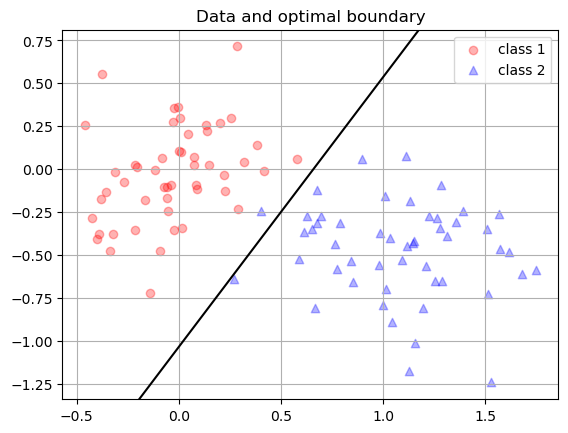

In [19]:
# optimal linear classifier
optw = np.matmul(mean1 - mean2, np.linalg.inv(cov1))
optb = np.matmul(optw, (mean1 + mean2)/2)
print(optw, optb)

draw_state(optw, optb, data1.cpu(), data2.cpu(), 'Data and optimal boundary')


n:



### Learning

Now we try several different levels of coding using pyTorch in order to obtain $\mathbf{w}$ and $b$ out of data. First, the subsequent update uses the gradient vector derived by taking the derivative of the objective function.



We consider the following regularized cross entropy objective:
\begin{eqnarray}
L = -\frac{1}{N}\sum_{i = 1}^N y\log f(\mathbf{x}; \mathbf{w}, b) + (1 - y)\log (1 - f(\mathbf{x}; \mathbf{w}, b)) 
+ \lambda(||\mathbf{w}||^2 + b^2),
\end{eqnarray}
with
\begin{eqnarray}
f(\mathbf{x}; \mathbf{w}, b) = \frac{1}{1 + \exp(\mathbf{w}^\top\mathbf{x} - b)},
\end{eqnarray}
and a small positive regularization constant $\lambda > 0$.

In [21]:
# Initialize parameters
w = torch.randn([1,dim], dtype=torch.float32, device=dev, requires_grad=True)
b = torch.randn([1,1], dtype=torch.float32, device=dev, requires_grad=True)

# extended w: [w, -b]
extw = torch.cat([w, -b], axis=1)
# data with '1' is appended: [X, 1]
extX = torch.cat((torch.cat([data1, data2], axis=0), \
                       torch.ones([datanum1 + datanum2, 1], device=dev)), axis=1)
labels = torch.cat([torch.ones(datanum1, device=dev), torch.zeros(datanum2, device=dev)])  # label of class 1: 1, label of class 2: 0


### Use the derivative of the loss function to update

The standard update of the parameters is as follows:

\begin{eqnarray}
\left(
\begin{array}{c}
\mathbf{w}_{t + 1} \\
b_{t + 1}
\end{array}
\right) = 
\left(
\begin{array}{c}
\mathbf{w}_{t} \\
b_{t}
\end{array}
\right) - 
\epsilon
\left(
\begin{array}{c}
\frac{dL}{d\mathbf{w}} \\
\frac{dL}{db} \\
\end{array}
\right),
\end{eqnarray}
with a small positive constant $\epsilon > 0$.

However, we can use a simpler code. We let $\mathbf{w}' = \left(\begin{array}{c}\mathbf{w} \\ -b \end{array} \right)$, the $f(\mathbf{x}; \mathbf{w}, b)$ function can be rewritten using $\mathbf{w}'$ as
\begin{eqnarray}
f(\mathbf{x}; \mathbf{w}') = f(\mathbf{x}; \mathbf{w}, b) = \frac{1}{1 + \exp(\mathbf{w}^\top\mathbf{x} - b)}
= \frac{1}{1 + \exp\left(\mathbf{w}'^\top\left(\begin{array}{c}\mathbf{x} \\ 1 \end{array}\right)\right)},
\end{eqnarray}

We can derive $\frac{dL}{d\mathbf{w}'}$ and make a new update rule.
\begin{eqnarray}
\mathbf{w}'_{t + 1} = \mathbf{w}_t - \epsilon \frac{dL}{d\mathbf{w}'},
\end{eqnarray}
with a small positive $\epsilon > 0$.

In [22]:
def update_w_vanilla(extw, extX, labels, num_update=100, step_size=0.001, reg_const=1):
    draw_state(extw[0,0:2].cpu().detach().numpy(), -extw[0,2].cpu().detach().numpy(), data1.cpu(), data2.cpu(), 'Before update')

    objective_history = []
    for i in range(num_update):
        ts = torch.matmul(extX, extw.T).T  # w^TX
        fs = logistic_function(ts)
        extw = extw + step_size*(torch.matmul(labels - fs, extX) - reg_const*extw)
        objective_history.append(float(get_loss(labels, fs[0]).cpu().detach().numpy()))

    draw_state(extw[0,0:2].cpu().detach().numpy(), -extw[0,2].cpu().detach().numpy(), data1.cpu(), data2.cpu(), 'Updated boundary')

    fig, ax = plt.subplots()
    ax.plot(objective_history)
    ax.set_title("objective function")
    
    return extw


Now we implemented our manual update code with the derivatives $\frac{dL}{d\mathbf{w}}$ and $\frac{dL}{db}$ that have been devied by us.

The update of the parameters show the update of the boundary. The boundary is determined by $\mathbf{w}$ and $b$.

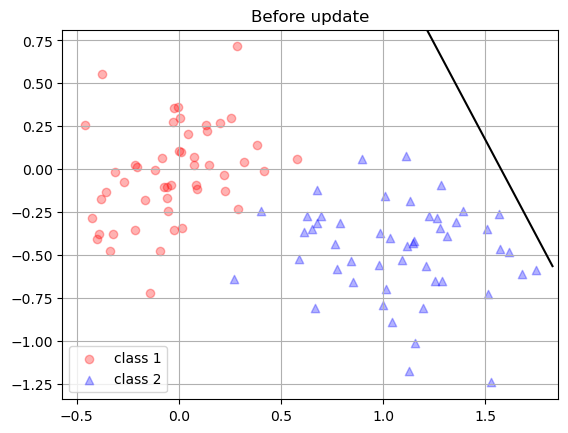

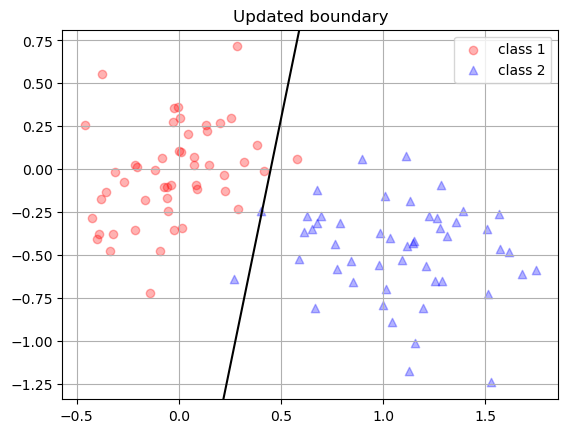

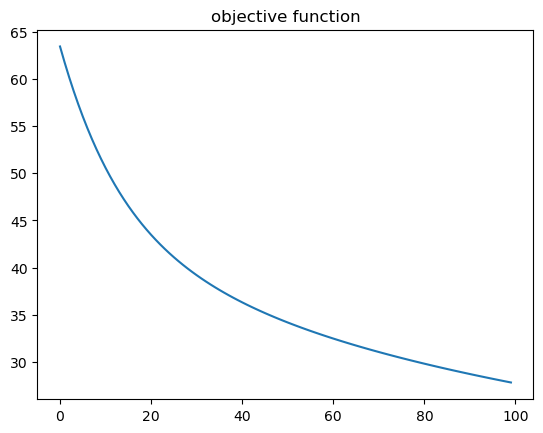

In [23]:
extw = update_w_vanilla(extw, extX, labels, num_update=100, step_size=0.001, reg_const=0)

Further update show improved results, and the objective function value keep decreases.

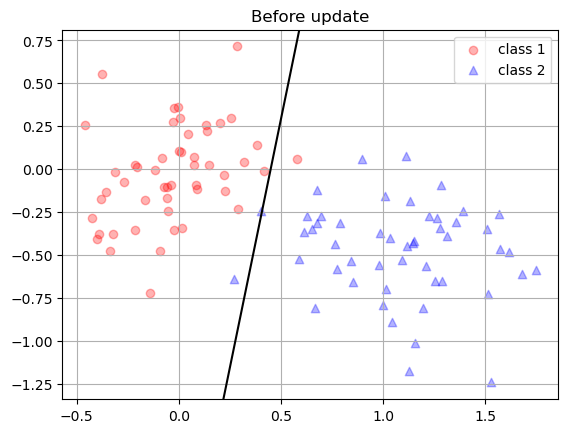

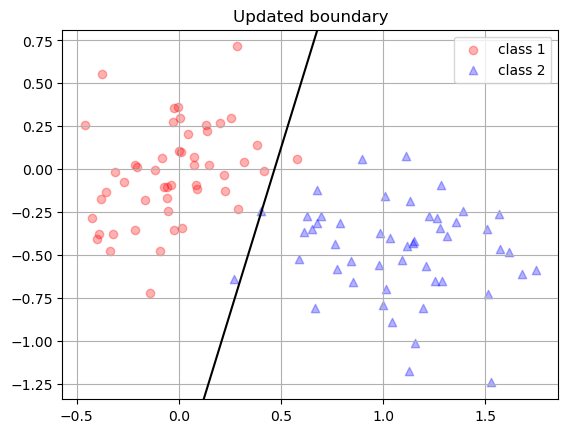

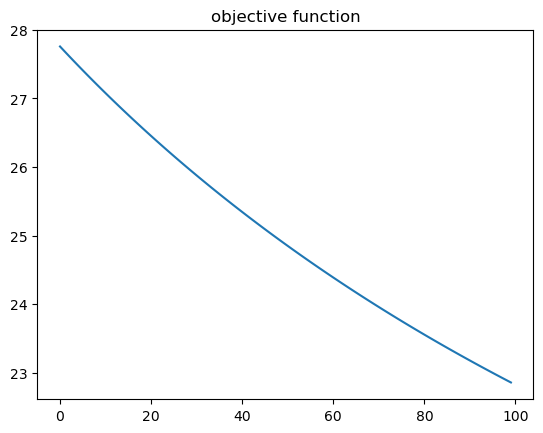

In [24]:
# Additional 100 updates
extw = update_w_vanilla(extw, extX, labels)

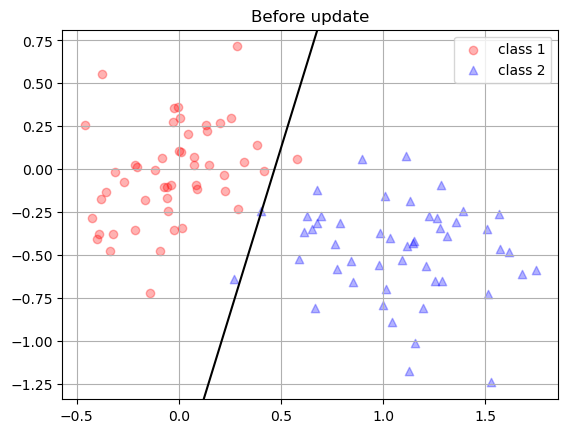

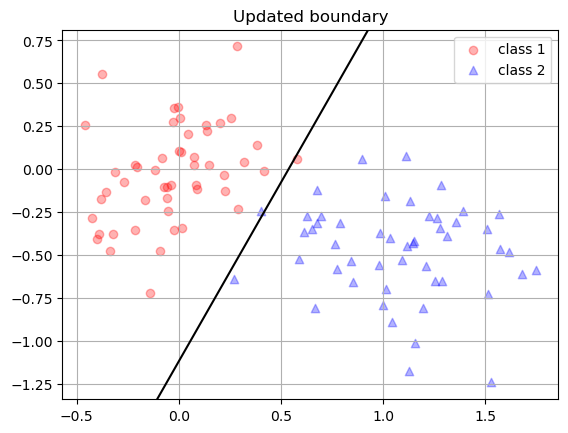

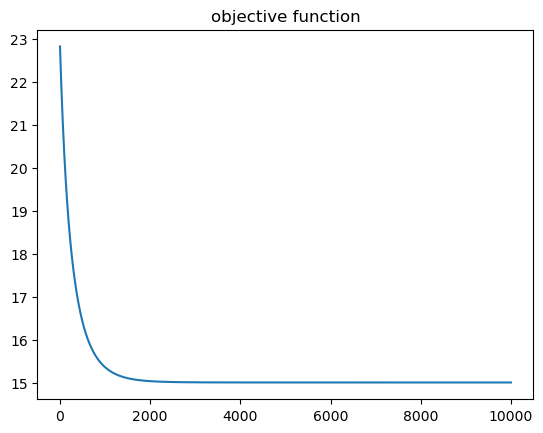

In [25]:
# After enough updates
extw = update_w_vanilla(extw, extX, labels, num_update=10000)

### Evaluation

Now we use the testing data to estimate the expected error for untrained data. The error is approximated $3\%$.

In [14]:
# data with '1' is appended: [X, 1]
extTstX = torch.cat([torch.cat([tstdata1, tstdata2], axis=0), \
                       torch.ones([tstdatanum1 + tstdatanum2, 1], device=dev)], axis=1)
labels = torch.cat([torch.ones(tstdatanum1, device=dev), torch.zeros(tstdatanum2, device=dev)])

ts = torch.matmul(extTstX, extw.T)  # w^TX
err_rate = torch.sum(torch.abs((ts.T > 0)*1. - labels))/(tstdatanum1 + tstdatanum2)
print(err_rate)

tensor(0.0320, device='cuda:1')


### Use torch optimization

We implemented the gradient descent algorithm using python code. Now we borrow some pre-implemented codes from pyTorch and see how the update in the previous example can be performed using basic optimization functions in pyTorch.

The following code performs one step of the update using the predefined information in optimizer.

```python
        cost = model.get_loss(data, labels)
        optimizer.zero_grad()
        cost.backward()
        optimizer.step()
```

We first make a sample class that keeps the parameters of prediction function $f(\mathbf{x}; \mathbf{w}, b)$ in the above example. Forward function implements the calculation of the function $f(\mathbf{x}; \mathbf{w}, b)$ with input $\mathbf{x}$.

In [56]:
# For test 1
class LogisticRegression_torch_0(torch.nn.Module):    
    def __init__(self, input_dim, output_dim):
        super(LogisticRegression_torch_0, self).__init__()
        self.w = torch.randn([1,dim], dtype=torch.float32, device=dev, requires_grad=True)
        self.b = torch.randn([1,1], dtype=torch.float32, device=dev, requires_grad=True)
    def forward(self, x):
        outputs = torch.sigmoid(torch.matmul(self.w, x.T) - self.b)
        return outputs



When we initialize the class, the parameters $\mathbf{w}$ and $b$ are also initialized with random floats. The update parameters should have the option "requres_grad=True."

In our test of pyTorch optimization functions, we use the two-norm of $\mathbf{w}$ ($=||\mathrm{w}||^2$) as our cost. Let's observe how the pyTorch optimization functions decrease the cost after a single step is taken.  

In [58]:
# Test 1
model = LogisticRegression_torch_0(input_dim=dim, output_dim=1).to(dev)

cost = torch.sum(model.w**2)
print("Cost before taking a single optimization step:", cost.item())
print('w:', model.w.cpu().detach().numpy())

optimizer = torch.optim.SGD([model.w, model.b], lr=0.01)
optimizer.zero_grad()
cost.backward()
optimizer.step()

cost = torch.sum(model.w**2)
print("Cost after taking a single optimization step:", cost.item())
print('w:', model.w.cpu().detach().numpy())


Cost before taking a single optimization step: 0.24553805589675903
w: [[0.29809797 0.39582276]]
Cost after taking a single optimization step: 0.23581476509571075
w: [[0.292136  0.3879063]]


We now construct a class with an implementation of the objective function:

```python
 get_loss(self, data, labels)
```

The loss is the cross entropy loss.

In [62]:
# For test 1
class LogisticRegression_torch1(torch.nn.Module):    
    def __init__(self, input_dim, output_dim):
        super(LogisticRegression_torch1, self).__init__()
        self.w = torch.randn([1,dim], dtype=torch.float32, device=dev, requires_grad=True)
        self.b = torch.randn([1,1], dtype=torch.float32, device=dev, requires_grad=True)
    def get_loss(self, data, labels):
        fs = self.forward(data)
        loss_val = torch.sum(-labels*torch.log(fs) - (1 - labels)*torch.log(1 - fs))
        return loss_val
    def forward(self, x):
        outputs = torch.sigmoid(torch.matmul(self.w, x.T) - self.b)
        return outputs


A series of updates is performed in the for loop:

In [63]:
def update_w_torch1(model, data, labels, num_update=100, step_size=0.001):
    draw_state(model.w[0].cpu().detach().numpy(), model.b[0].cpu().detach().numpy(), data1.cpu(), data2.cpu(), 'Before update')

    optimizer = torch.optim.SGD([model.w, model.b], lr=step_size)
    objective_history = []

    for i in range(num_update):
        cost = model.get_loss(data, labels)
        optimizer.zero_grad()
        cost.backward()
        optimizer.step()
        objective_history.append(float(cost))
#     print(objective_history)

    draw_state(model.w[0].cpu().detach().numpy(), model.b[0].cpu().detach().numpy(), data1.cpu(), data2.cpu(), 'Updated boundary')

    fig, ax = plt.subplots()
    ax.plot(objective_history)
    ax.set_title("objective function")


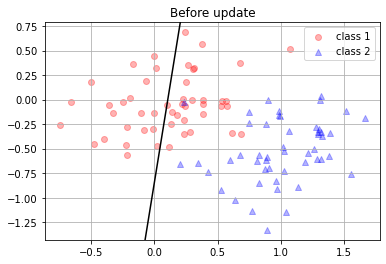

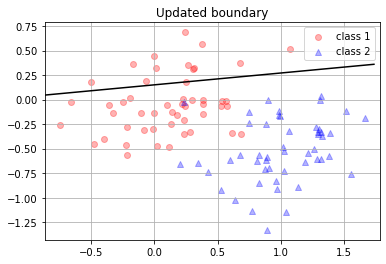

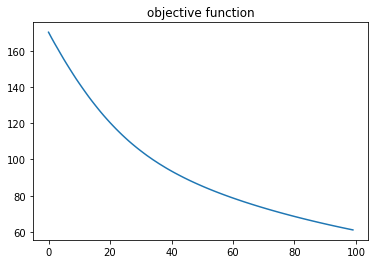

In [17]:
# data with '1' is appended: [X, 1]
data = torch.cat([data1, data2], axis=0)
labels = torch.cat([torch.ones(datanum1, device=dev), torch.zeros(datanum2, device=dev)])  # label of class 1: 1, label of class 2: 0

model = LogisticRegression_torch1(input_dim=dim, output_dim=1).to(dev)
update_w_torch1(model, data, labels, num_update=100, step_size=0.001)

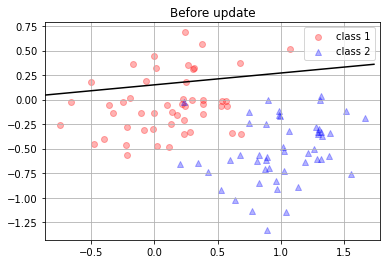

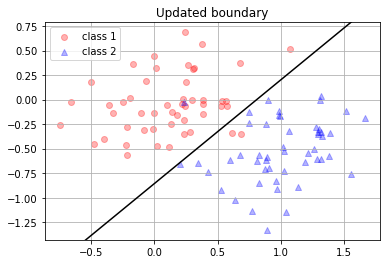

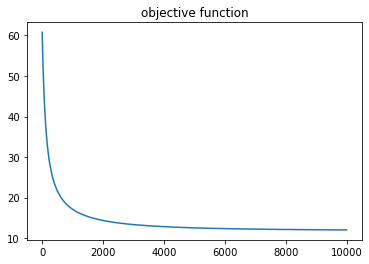

In [18]:
update_w_torch1(model, data, labels, num_update=10000, step_size=0.001)

### Use torch.nn.Module parameters

Now the variables are modified from Torch tensor to those generated from torch.nn.Parameter. The remaining parts remain unchanged.


In [70]:
# For test 2
class LogisticRegression_torch2(torch.nn.Module):    
    def __init__(self, input_dim, output_dim):
        super(LogisticRegression_torch2, self).__init__()
        self.w = nn.Parameter(distributions.Normal(0, 1).sample(sample_shape=[1,dim]))
        self.b = nn.Parameter(distributions.Normal(0, 1).sample(sample_shape=[1,1]))
    def get_loss(self, data, labels):
        fs = self.forward(data)
        loss_val = torch.sum(-labels*torch.log(fs) - (1 - labels)*torch.log(1 - fs))
        return loss_val        
    def forward(self, x):
        outputs = torch.sigmoid(torch.matmul(self.w, x.T) - self.b)
        return outputs


For the update, optimizer is changed to keep the model.parameters.

In [71]:
def update_w_torch2(model, data, labels, num_update=100, step_size=0.001):
    draw_state(model.w[0].cpu().detach().numpy(), model.b[0].cpu().detach().numpy(), data1.cpu(), data2.cpu(), 'Before update')

    optimizer = torch.optim.SGD(model.parameters(), lr=step_size)
    objective_history = []

    for i in range(num_update):
        cost = model.get_loss(data, labels)
        optimizer.zero_grad()
        cost.backward()
        optimizer.step()
        objective_history.append(float(cost))
#     print(objective_history)

    draw_state(model.w[0].cpu().detach().numpy(), model.b[0].cpu().detach().numpy(), data1.cpu(), data2.cpu(), 'Updated boundary')

    fig, ax = plt.subplots()
    ax.plot(objective_history)
    ax.set_title("objective function")


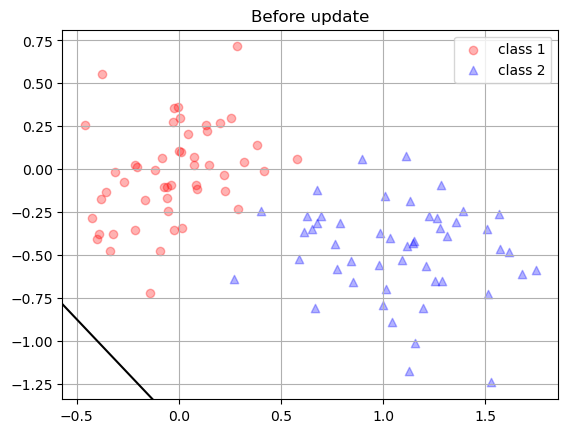

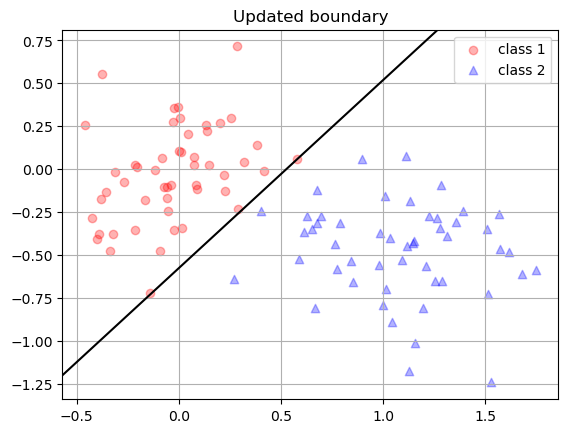

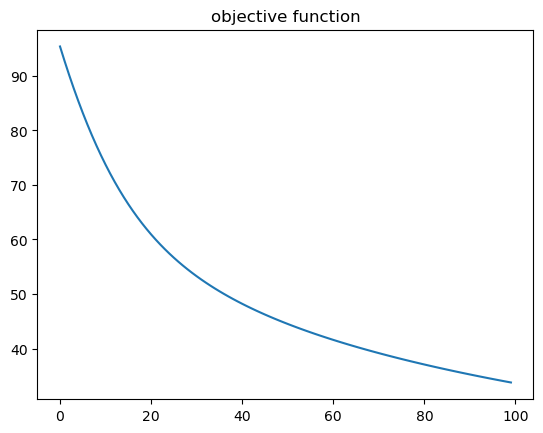

In [72]:
# data with '1' is appended: [X, 1]
data = torch.cat([data1, data2], axis=0)
labels = torch.cat([torch.ones(datanum1, device=dev), torch.zeros(datanum2, device=dev)])  # label of class 1: 1, label of class 2: 0

model = LogisticRegression_torch2(input_dim=dim, output_dim=1).to(dev)
update_w_torch2(model, data, labels, num_update=100, step_size=0.001)

After $10000$ more iterations,

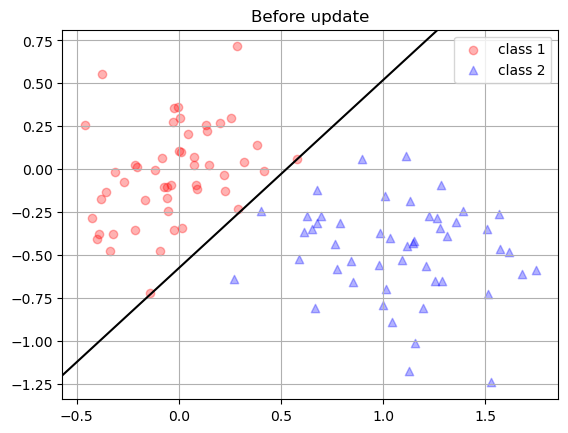

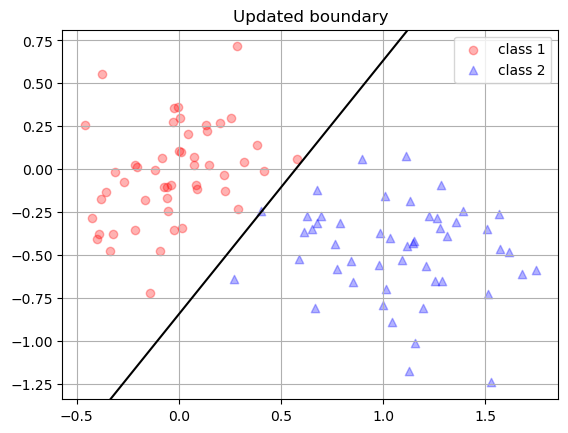

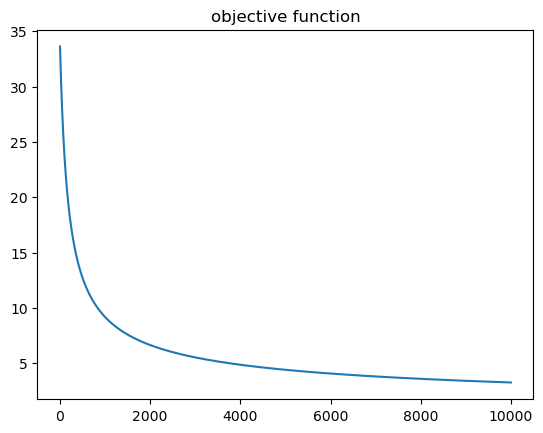

In [76]:
update_w_torch2(model, data, labels, num_update=10000, step_size=0.001)

### Use torch nn.Linear module

Now the coding with pyTorch can be simple if we find an appropriate pre-implementation in the pyTorch library. The implementation of our linear operation, $\mathbf{w}^\top\mathbf{x} - b$ can be replace using "torch.nn.Linear" module. We simply obtain the "torch.nn.Linear" module and use the parameters inside the Linear module for the update.

In [78]:
# For test nn.Linear
class LogisticRegression_Linear(torch.nn.Module):    
    def __init__(self, input_dim, output_dim):
        super(LogisticRegression_Linear, self).__init__()
        self.linear = torch.nn.Linear(input_dim, output_dim)
    def get_loss(self, data, labels):
        fs = self.forward(data)
        loss_val = torch.sum(-labels*torch.log(fs) - (1 - labels)*torch.log(1 - fs))
        return loss_val        
    def forward(self, x):
        outputs = torch.sigmoid(self.linear(x)).T
        return outputs


In this case, direct access to the variables in the module is naturally limited. The programming is becoming more like a black box. In order to investigate the learning process, you can replace values of the parameters and access the values of the parameters using the following methods:

Make a class having the nn.Linear module:

In [80]:
model = LogisticRegression_Linear(input_dim=dim, output_dim=1).to(dev)

Put your own value in the nn.Linear parameter and see if you can calculate the loss function using the updated values:

In [83]:
print('=====Set a nn.Linear parameter and find the calculated loss=====')
model.linear.weight.data[0,0] = 1
model.linear.weight.data[0,1] = 1
# model.linear.bias.data[0] = 0
model.linear.bias.data[0] = -1
print('weight: \n', model.linear.weight.data, model.linear.bias.data)
print('Model loss: \n', model.get_loss(data, labels))
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
cost = model.get_loss(data, labels)
optimizer.zero_grad()
cost.backward()
optimizer.step()
print('Updated weight: \n', model.linear.weight.data, model.linear.bias.data)


=====Set a nn.Linear parameter and find the calculated loss=====
weight: 
 tensor([[1., 1.]], device='cuda:1') tensor([-1.], device='cuda:1')
Model loss: 
 tensor(95.2999, device='cuda:1', grad_fn=<SumBackward0>)
Updated weight: 
 tensor([[0.7512, 1.0698]], device='cuda:1') tensor([-0.8352], device='cuda:1')


The above calculation should be confirmed using our own calculation:

In [85]:
print('\n=====Without Torch=====')
extw = torch.tensor([[1., 1., -1.]], device=dev) # b = -extw[2]
print('weight: \n', extw)
extX = torch.cat((data, torch.ones([len(data), 1], device=dev)), axis=1)
ts = torch.matmul(extX, extw.T).T  # w^TX
print('Conventional loss \n', get_loss(labels, logistic_function(ts)))
fs = logistic_function(ts)
extw = extw + 0.01*(torch.matmul(labels - fs, extX))
print('Updated weight: \n', extw)

print('\n========== Compare updated bias ============')
print(model.linear.bias.data, 'vs', extw[0,2])


=====Without Torch=====
weight: 
 tensor([[ 1.,  1., -1.]], device='cuda:1')
Conventional loss 
 tensor(95.2999, device='cuda:1')
Updated weight: 
 tensor([[ 0.7512,  1.0698, -0.8352]], device='cuda:1')

========== Compare updated bias ============
tensor([-0.8352], device='cuda:1') vs tensor(-0.8352, device='cuda:1')


In the update function, we use model.linear.weight instead of model.w or model.b, as it is the official name of the nn.Linear module. Without parameter investigation (for only learning), we can use the previous update function. 

In [89]:
def update_w_torch_Linear(model, data, labels, num_update=100, step_size=0.001):
    draw_state(model.linear.weight[0].cpu().detach().numpy(), \
               -model.linear.bias.cpu().detach().numpy(), data1.cpu(), data2.cpu(), 'Before update')

    optimizer = torch.optim.SGD(model.parameters(), lr=step_size)
    objective_history = []

    for i in range(num_update):
        cost = model.get_loss(data, labels)
        optimizer.zero_grad()
        cost.backward()
        optimizer.step()
        objective_history.append(float(cost))
#     print(objective_history)

    draw_state(model.linear.weight[0].cpu().detach().numpy(), \
               -model.linear.bias.cpu().detach().numpy(), data1.cpu(), data2.cpu(), 'Updated boundary')

    fig, ax = plt.subplots()
    ax.plot(objective_history)
    ax.set_title("objective function")


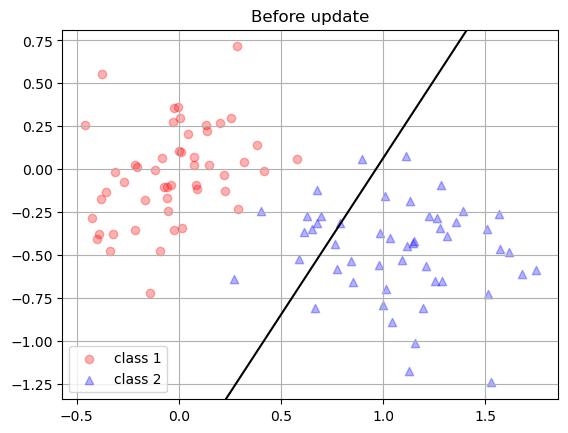

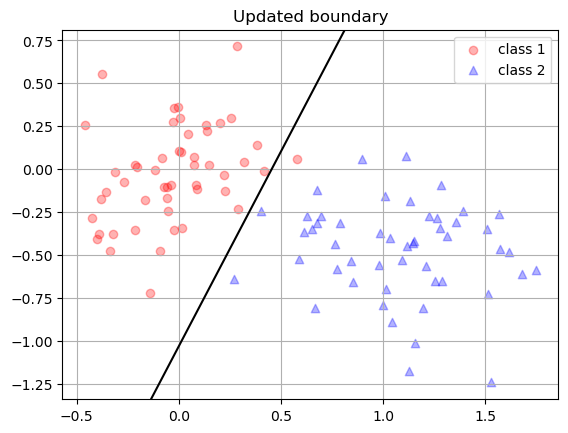

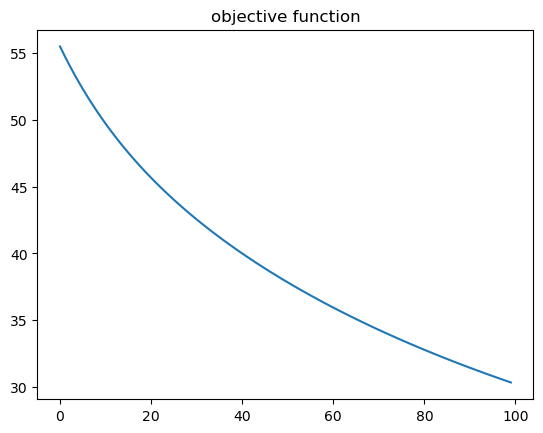

In [90]:
# data with '1' is appended: [X, 1]
data = torch.cat([data1, data2], axis=0)
labels = torch.cat([torch.ones(datanum1, device=dev), torch.zeros(datanum2, device=dev)])  # label of class 1: 1, label of class 2: 0

model = LogisticRegression_Linear(input_dim=dim, output_dim=1).to(dev)
update_w_torch_Linear(model, data, labels, num_update=100, step_size=0.001)

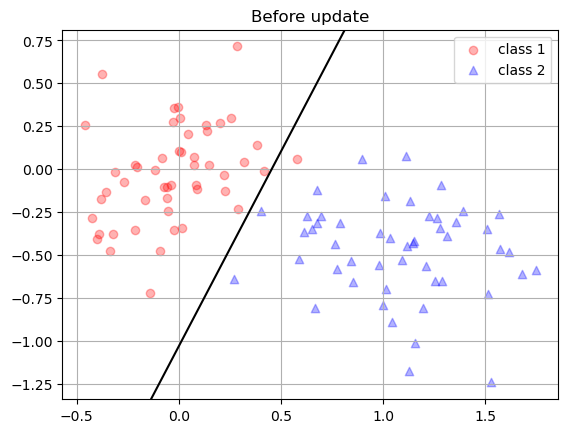

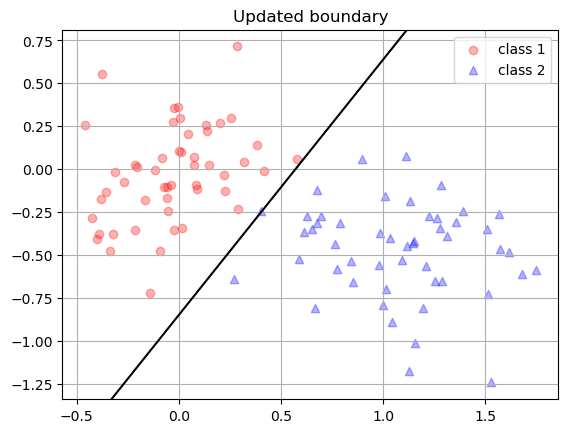

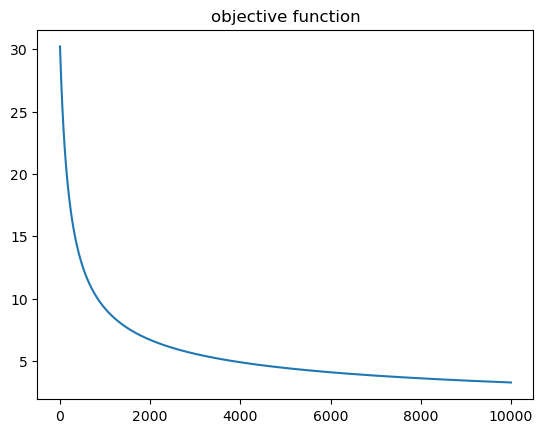

In [91]:
update_w_torch_Linear(model, data, labels, num_update=10000, step_size=0.001)

### Logistic regression

We now put all together and make a class to perform Logistic regression.

In [92]:
class LogisticRegression(torch.nn.Module):    
    def __init__(self, input_dim, output_dim):
        super(LogisticRegression, self).__init__()
        self.linear = torch.nn.Linear(input_dim, output_dim)
    def get_loss(self, data, labels):
        fs = self.forward(data)
        loss_val = torch.sum(-labels*torch.log(fs) - (1 - labels)*torch.log(1 - fs))
        return loss_val        
    def two_norm(self):
        outputs = torch.sum(self.linear.weight**2)
#         outputs = torch.sum(self.linear.weight**2) + torch.sum(self.linear.bias**2)
        return outputs
    def get_loss_2norm(self, data, labels, reg_const = 1.):
        fs = self.forward(data)
        loss_val = torch.sum(-labels*torch.log(fs) - \
            (1 - labels)*torch.log(1 - fs)) \
            + reg_const*self.two_norm()
        return loss_val        
    def getExtw(self):
        return torch.cat([model.linear.weight[0], model.linear.bias])
    def linear_out(self, x):
        outputs = self.linear(x)
        return outputs[0]    # make predictions
    def forward(self, x):
        outputs = torch.sigmoid(self.linear(x)).T
        return outputs

model = LogisticRegression(input_dim=dim, output_dim=1).to(dev)


In [93]:
def update_w(model, data, labels, num_update=100, step_size=0.001, reg_const=1):
    draw_state(model.linear.weight[0].cpu().detach().numpy(), \
               -model.linear.bias.cpu().detach().numpy(), data1.cpu(), data2.cpu(), 'Before update')

    optimizer = torch.optim.SGD(model.parameters(), lr=step_size)
    objective_history = []

    for i in range(num_update):
        cost = model.get_loss_2norm(data, labels, reg_const)
        optimizer.zero_grad()
        cost.backward()
        optimizer.step()
        objective_history.append(float(cost))
#     print(objective_history)

    draw_state(model.linear.weight[0].cpu().detach().numpy(), \
               -model.linear.bias.cpu().detach().numpy(), data1.cpu(), data2.cpu(), 'Updated boundary')

    fig, ax = plt.subplots()
    ax.plot(objective_history)
    ax.set_title("objective function")


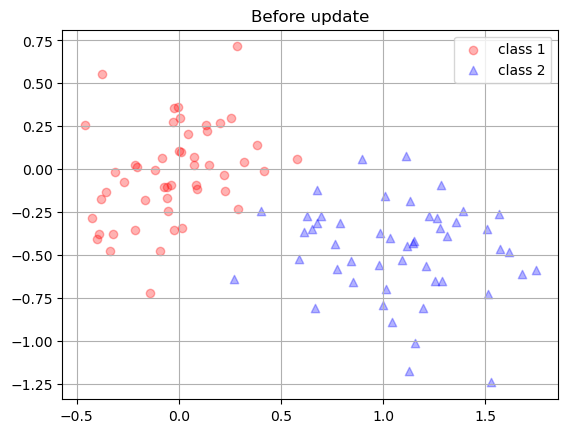

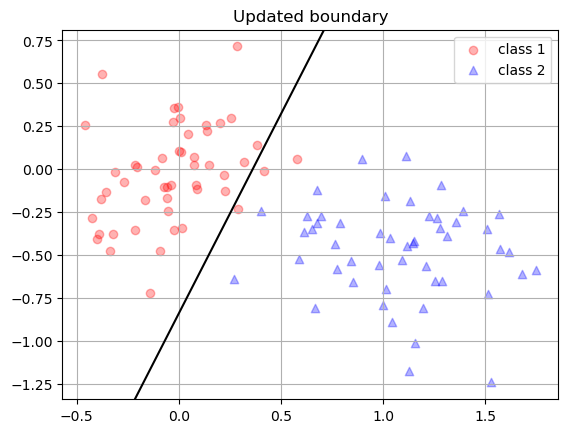

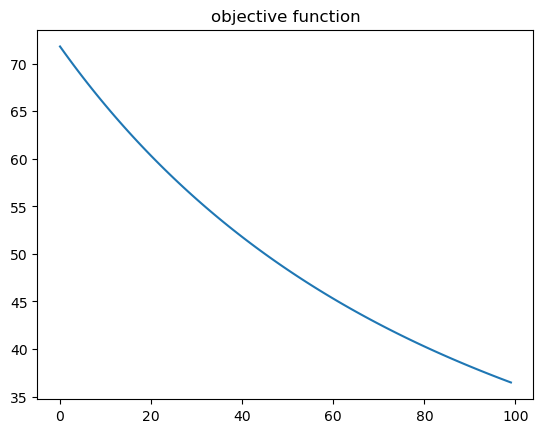

In [94]:
# data with '1' is appended: [X, 1]
data = torch.cat([data1, data2], axis=0)
labels = torch.cat([torch.ones(datanum1, device=dev), torch.zeros(datanum2, device=dev)])  # label of class 1: 1, label of class 2: 0

model = LogisticRegression(input_dim=dim, output_dim=1).to(dev)
update_w(model, data, labels, num_update=100, step_size=0.001, reg_const=0)

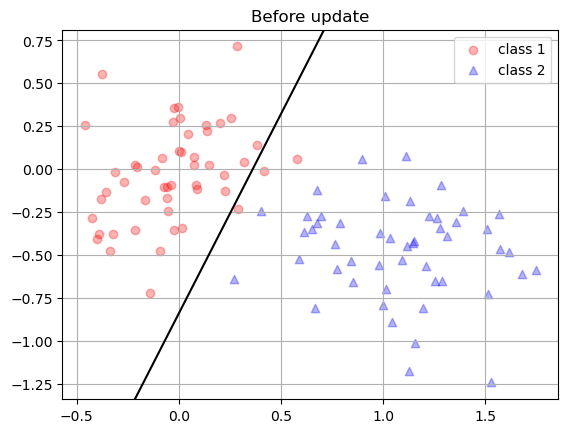

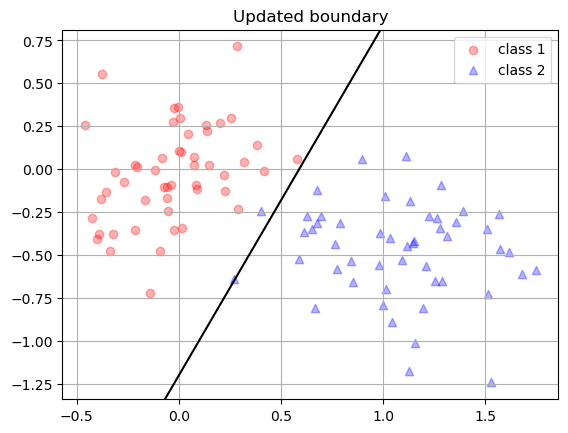

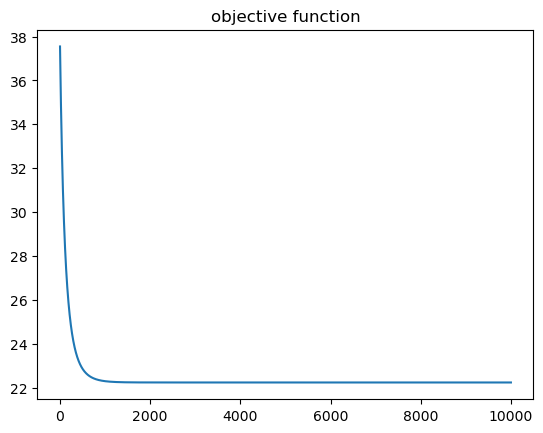

In [95]:
update_w(model, data, labels, num_update=10000, step_size=0.001, reg_const=.5)

Note that with regularization, the loss function arrives at a plateu.

Various methods to debug the modules can be used. For example, we can investigate the output of the Logistic regression function using 'forward' function. We can make our own function for debug, such ans 'linear_out' in this class.

In [96]:
model.linear.weight.data[0,0] = 1
model.linear.weight.data[0,1] = 1
# model.linear.bias.data[0] = 0
model.linear.bias.data[0] = 1
intput_sampe = torch.ones([1,2], device=dev)
print('input sample: \n', intput_sampe)
print('weight: \n', model.linear.weight.data, model.linear.bias.data)
print('Network output:\n', model.forward(intput_sampe))
print('Linear output:\n', model.linear_out(intput_sampe))

data_temp = torch.tensor([[1,0],[0,0],[1,1],[0,0]], dtype=torch.float32, device=dev)
labels_temp = torch.tensor([[1,0,1,0]], device=dev)
print('Model Loss: \n', model.get_loss(data_temp, labels_temp))
# print()

input sample: 
 tensor([[1., 1.]], device='cuda:1')
weight: 
 tensor([[1., 1.]], device='cuda:1') tensor([1.], device='cuda:1')
Network output:
 tensor([[0.9526]], device='cuda:1', grad_fn=<PermuteBackward0>)
Linear output:
 tensor([3.], device='cuda:1', grad_fn=<SelectBackward0>)
Model Loss: 
 tensor(2.8020, device='cuda:1', grad_fn=<SumBackward0>)


In [32]:
# For test
ts = torch.matmul(model.linear.weight, data_temp.T) + model.linear.bias
print(torch.sigmoid(ts))
print(logistic_function(ts))
print(model.forward(data_temp).T)
print('Model loss', model.get_loss(data_temp, labels_temp))
print('True loss', get_loss(labels_temp, logistic_function(ts)))

tensor([[0.8808, 0.7311, 0.9526, 0.7311]], device='cuda:1',
       grad_fn=<SigmoidBackward0>)
tensor([[0.8808, 0.7311, 0.9526, 0.7311]], device='cuda:1',
       grad_fn=<MulBackward0>)
tensor([[0.8808],
        [0.7311],
        [0.9526],
        [0.7311]], device='cuda:1', grad_fn=<PermuteBackward0>)
Model loss tensor(2.8020, device='cuda:1', grad_fn=<SumBackward0>)
True loss tensor(2.8020, device='cuda:1', grad_fn=<SumBackward0>)


#### We can access the variables using the following variables:

In [97]:
model = LogisticRegression(input_dim=dim, output_dim=1).to(dev)

In [98]:
model.linear.weight

Parameter containing:
tensor([[-0.3974, -0.2128]], device='cuda:1', requires_grad=True)

In [99]:
model.linear.bias

Parameter containing:
tensor([-0.1293], device='cuda:1', requires_grad=True)

#### We can test the function

In [100]:
model.get_loss(data=torch.tensor([[1,0],[0,0],[1,1],[0,0]], dtype=torch.float32, device=dev), \
               labels=torch.tensor([[1,0,1,0]], device=dev))

tensor(3.3817, device='cuda:1', grad_fn=<SumBackward0>)

With different labels,

In [101]:
model.get_loss(torch.tensor([[1,0],[0,0],[1,1],[0,0]], dtype=torch.float32, device=dev), \
               torch.tensor([[1,1,1,0]], device=dev))

tensor(3.5110, device='cuda:1', grad_fn=<SumBackward0>)